In [1]:
import warnings
warnings.filterwarnings('ignore')

import itertools
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sys

from itertools import combinations 
from scipy.stats import boxcox
from scipy.stats import linregress
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from statsmodels.stats.anova import anova_lm

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

# import utils
sys.path.append("../../../utils")
from plotting_utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

In [3]:
np.random.seed(2019)

In [4]:
QUANT_ALPHA = 0.05

## functions

In [5]:
def calculate_gc(row, col):
    cs = row[col].count("C")
    gs = row[col].count("G")
    gc = (cs+gs)/len(row[col])
    return gc

In [6]:
def calculate_cpg(row, col):
    cpgs = row[col].count("CG")
    cpg = cpgs/len(row[col])
    return cpg

In [7]:
def sig_status(row):
    if row.padj_trans < 0.05:
        return "sig"
    else:
        return "not sig"

In [8]:
def neg_odds(row):
    if row["sig_status"] == "sig hESC":
        return -row["hESC_odds"]
    elif row["sig_status"] == "sig mESC":
        return row["mESC_odds"]
    else:
        return np.nan

In [9]:
def direction_match(row):
    if row.activ_or_repr == "activating":
        if row.beta_trans < 0 and row.corrected_l2fc < 0:
            return "match"
        elif row.beta_trans > 0 and row.corrected_l2fc > 0:
            return "match"
        else:
            return "no match"
    elif row.activ_or_repr == "repressing":
        if row.beta_trans < 0 and row.corrected_l2fc > 0:
            return "match"
        elif row.beta_trans > 0 and row.corrected_l2fc < 0:
            return "match"
        else:
            return "no match"
    else:
        return "unclear"

## variables

In [10]:
human_motifs_f = "../../../data/04__mapped_motifs/human_motifs_filtered.txt.gz"
mouse_motifs_f = "../../../data/04__mapped_motifs/mouse_motifs_filtered.txt.gz"

In [11]:
motif_info_dir = "../../../misc/01__motif_info"
motif_map_f = "%s/00__lambert_et_al_files/00__metadata/curated_motif_map.txt" % motif_info_dir
motif_info_f = "%s/00__lambert_et_al_files/00__metadata/motif_info.txt" % motif_info_dir

In [12]:
sig_motifs_f = "../../../data/04__mapped_motifs/sig_motifs.txt"

In [13]:
tss_map_f = "../../../data/01__design/01__mpra_list/mpra_tss.with_ids.RECLASSIFIED.txt"

In [14]:
index_f = "../../../data/01__design/02__index/TWIST_pool4_v8_final.with_element_id.txt.gz"

In [15]:
data_f = "../../../data/02__mpra/03__results/all_processed_results.txt"

In [16]:
expr_dir = "../../../data/03__rna_seq/04__TF_expr"
orth_expr_f = "%s/orth_TF_expression.txt" % expr_dir
human_expr_f = "%s/hESC_TF_expression.txt" % expr_dir
mouse_expr_f = "%s/mESC_TF_expression.txt" % expr_dir

In [17]:
orth_f = "../../../misc/00__ensembl_orthologs/ensembl96_human_mouse_orths.txt.gz"

## 1. import data

In [18]:
index = pd.read_table(index_f, sep="\t")
index_elem = index[["element", "tile_type", "element_id", "name", "tile_number", "chrom", "strand", "actual_start", 
                    "actual_end", "dupe_info"]]
index_elem = index_elem.drop_duplicates()

In [19]:
tss_map = pd.read_table(tss_map_f, sep="\t")
tss_map.head()

,hg19_id,mm9_id,cage_id_hg19,cage_id_mm9,name_peak_hg19,name_peak_mm9,biotype_hg19,biotype_mm9,minimal_biotype_hg19,minimal_biotype_mm9,...,end_tss_mm9,strand_tss_mm9,avg_exp_hg19,avg_exp_mm9,stem_exp_hg19,stem_exp_mm9,max_cage_hg19,max_cage_mm9,orig_species,har
0,h.0,m.0,"chr1:2984976..2984989,-","chr4:154011655..154011673,+",ENSG00000177133.6,ENSMUSG00000085069.2,divergent,divergent,lncRNA,lncRNA,...,154011664,+,0.1,0.43,0.027777800000000002,0.0175,367.0,2286.0,human,False
1,h.1,m.0,"chr1:2984997..2985037,-","chr4:154011655..154011673,+",ENSG00000177133.6,ENSMUSG00000085069.2,divergent,divergent,lncRNA,lncRNA,...,154011664,+,0.29,0.43,0.0311111,0.0175,367.0,2286.0,human,False
2,h.2,m.1,"chr1:2985420..2985438,-","chr4:154011250..154011257,+",ENSG00000177133.6,ENSMUSG00000085069.2,divergent,divergent,lncRNA,lncRNA,...,154011253,+,2.54,0.85,0.07111110000000001,0.0,6966.0,1361.0,human,False
3,h.3,m.2,"chr1:8086546..8086571,+","chr4:150229039..150229050,-",ENSG00000238290.1,ENSMUSG00000078492.3,divergent,antisense,lncRNA,lncRNA,...,150229045,-,0.3,0.14,0.10444400000000001,0.0,960.0,123.0,human,False
4,h.4,m.3,"chr1:26498321..26498327,-","chr4:133799669..133799683,+",ENSG00000236782.1,ENSMUSG00000086322.7,antisense,protein_coding,other,mRNA,...,133799678,+,0.19,0.25,0.03,0.0,753.0,770.0,human,False


In [20]:
human_motifs = pd.read_table(human_motifs_f, sep="\t")
human_motifs.head()

,#pattern name,sequence name,start,stop,strand_x,score,p-value,q-value,matched sequence,elem_key,...,dupe_info,tss_id,species,tss_tile_num,hg19_id,biotype_hg19,minimal_biotype_hg19,stem_exp_hg19,orig_species,hg19_index
0,ZNF785,elem_5191,70,98,+,41.1224,3.060000e-16,1.100000e-11,ACACGCACACACACACACACACACACACA,elem_5191,...,725.1.0.0,h.793,HUMAN,tile2,h.793,protein_coding,mRNA,0.0,human,h.793__tile2
1,ZNF785,elem_5191,84,112,+,30.8673,6.900000e-11,4.190000e-07,ACACACACACACACACGCACGCACACACG,elem_5191,...,725.1.0.0,h.793,HUMAN,tile2,h.793,protein_coding,mRNA,0.0,human,h.793__tile2
2,ZNF785,elem_5191,68,96,+,30.1633,1.100000e-10,6.350000e-07,GCACACGCACACACACACACACACACACA,elem_5191,...,725.1.0.0,h.793,HUMAN,tile2,h.793,protein_coding,mRNA,0.0,human,h.793__tile2
3,ZNF785,elem_5191,80,108,+,30.0000,1.220000e-10,6.990000e-07,ACACACACACACACACACACGCACGCACA,elem_5191,...,725.1.0.0,h.793,HUMAN,tile2,h.793,protein_coding,mRNA,0.0,human,h.793__tile2
4,ZNF785,elem_5191,82,110,+,29.4898,1.690000e-10,9.440000e-07,ACACACACACACACACACGCACGCACACA,elem_5191,...,725.1.0.0,h.793,HUMAN,tile2,h.793,protein_coding,mRNA,0.0,human,h.793__tile2


In [21]:
mouse_motifs = pd.read_table(mouse_motifs_f, sep="\t")
mouse_motifs.head()

,#pattern name,sequence name,start,stop,strand_x,score,p-value,q-value,matched sequence,elem_key,...,dupe_info,tss_id,species,tss_tile_num,mm9_id,biotype_mm9,minimal_biotype_mm9,stem_exp_mm9,orig_species,mm9_index
0,ZNF785,elem_1730,22,50,+,41.2245,2.570000e-16,1.100000e-11,ACACACACACACACACGCACACACACACA,elem_1730,...,9349.1.0.0,m.2316,MOUSE,tile2,m.2316,no cage activity,no CAGE activity,no cage activity,human,m.2316__tile2
1,ZNF785,elem_1730,34,62,+,41.1224,3.060000e-16,1.100000e-11,ACACGCACACACACACACACACACACACA,elem_1730,...,9349.1.0.0,m.2316,MOUSE,tile2,m.2316,no cage activity,no CAGE activity,no cage activity,human,m.2316__tile2
2,ZNF785,elem_1730,8,36,+,40.5204,1.250000e-15,1.100000e-11,ACACACACACACACACACACACACACACA,elem_1730,...,9349.1.0.0,m.2316,MOUSE,tile2,m.2316,no cage activity,no CAGE activity,no cage activity,human,m.2316__tile2
3,ZNF785,elem_1730,40,68,+,40.5204,1.250000e-15,1.100000e-11,ACACACACACACACACACACACACACACA,elem_1730,...,9349.1.0.0,m.2316,MOUSE,tile2,m.2316,no cage activity,no CAGE activity,no cage activity,human,m.2316__tile2
4,ZNF785,elem_1730,42,70,+,40.5204,1.250000e-15,1.100000e-11,ACACACACACACACACACACACACACACA,elem_1730,...,9349.1.0.0,m.2316,MOUSE,tile2,m.2316,no cage activity,no CAGE activity,no cage activity,human,m.2316__tile2


In [22]:
motif_info = pd.read_table(motif_info_f, sep="\t")
motif_info.head()

,Ensembl ID,HGNC symbol,Motif evidence,Motif ID,Motif type,Motif source,CIS-BP ID,Best Motif(s)? (Figure 2A)
0,ENSG00000267281,AC023509.3,"Inferred - ATF7 (100% AA Identity, Homo sapiens)",ATF7_eDBD_HT-SELEX,HT-SELEX,Yin2017,M08490_1.94d,True
1,ENSG00000267281,AC023509.3,"Inferred - ATF7 (100% AA Identity, Homo sapiens)",ATF7_eDBD_Methyl-HT-SELEX,Methyl-HT-SELEX,Yin2017,M08491_1.94d,NaN
2,ENSG00000267281,AC023509.3,"Inferred - Atf7 (98% AA Identity, Mus musculus)",3T3L1-Atf7_GSE56872,Misc,HOMER,M06975_1.94d,NaN
3,ENSG00000264668,AC138696.1,"Inferred - ZFP41 (100% AA Identity, Homo sapiens)",ZFP41_FL_HT-SELEX,HT-SELEX,Yin2017,M09315_1.94d,True
4,ENSG00000264668,AC138696.1,"Inferred - ZFP41 (100% AA Identity, Homo sapiens)",ZFP41_FL_Methyl-HT-SELEX,Methyl-HT-SELEX,Yin2017,M09316_1.94d,NaN


In [23]:
sig_motifs = pd.read_table(sig_motifs_f)
sig_motifs = sig_motifs[sig_motifs["padj"] < 0.05]
print(len(sig_motifs))
sig_motifs.head()

487


,index,lr_test,pval,rsq,beta,padj,short_id,HGNC symbol,activ_or_repr,no_CAGE_enr,eRNA_enr,lncRNA_enr,mRNA_enr
0,HKR1,6.281798,0.012198,0.000384,0.048118,0.037451,HKR1,HKR1,activating,NaN,NaN,NaN,3.0
1,M00144_1,10.738762,0.001049,0.000657,-0.275327,0.004341,M00144_1,ARID5A,repressing,0.0,NaN,NaN,NaN
2,M00224_1,8.999747,0.002700,0.000550,-0.228712,0.010206,M00224_1,TWIST2,repressing,0.0,NaN,NaN,NaN
3,M00226_1,6.933266,0.008461,0.000424,0.133341,0.027823,M00226_1,ARNT,activating,NaN,NaN,NaN,NaN
4,M00242_1,18.650533,0.000016,0.001140,-0.321524,0.000096,M00242_1,SCX,repressing,NaN,1.0,NaN,NaN


In [24]:
data = pd.read_table(data_f)
data.head()

,hg19_id,chr_tss_hg19,start_tss_hg19,biotype_hg19,cage_id_hg19,name_peak_hg19,minimal_biotype_hg19,stem_exp_hg19,mm9_id,chr_tss_mm9,...,trans_mouse_status,trans_human_status_det,trans_mouse_status_det,trans_status_one,trans_status_det_one,logFC_trans_one,logFC_int,fdr_int,cis_trans_int_status,cis_trans_int_status_det
0,h.2,chr1,2985430.0,divergent,"chr1:2985420..2985438,-",ENSG00000177133.6,lncRNA,0.07111110000000001,m.1,chr4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,-0.333118,-0.035380,0.988785,no cis/trans int. effect,no cis/trans int. effect
1,h.3,chr1,8086552.0,divergent,"chr1:8086546..8086571,+",ENSG00000238290.1,lncRNA,0.10444400000000001,m.2,chr4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,0.536610,-0.387857,0.921562,no cis/trans int. effect,no cis/trans int. effect
2,h.4,chr1,26498322.0,antisense,"chr1:26498321..26498327,-",ENSG00000236782.1,other,0.03,m.3,chr4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,0.260673,-0.192854,0.959265,no cis/trans int. effect,no cis/trans int. effect
3,h.5,chr1,65533428.0,intergenic,"chr1:65533390..65533443,-",ENSG00000231485.1,lncRNA,0.841111,m.4,chr4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,0.439975,-0.723633,0.197618,no cis/trans int. effect,no cis/trans int. effect
4,h.6,chr1,65533462.0,intergenic,"chr1:65533457..65533465,-",ENSG00000231485.1,lncRNA,0.116667,m.4,chr4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,-0.267503,-0.511763,0.453490,no cis/trans int. effect,no cis/trans int. effect


In [25]:
orth_expr = pd.read_table(orth_expr_f, sep="\t")
orth_expr.head()

,gene_id_human,gene_name_human,mean_tpm_human,gene_id_mouse,gene_name_mouse,mean_tpm_mouse,baseMean,log2FoldChange,lfcSE,padj,sig
0,ENSG00000197921,HES5,101.620874,ENSMUSG00000048001,Hes5,0.000000,42.463063,9.220488,1.288307,1.707594e-12,sig
1,ENSG00000142611,PRDM16,127.168363,ENSMUSG00000039410,Prdm16,1160.183127,726.532277,-3.087431,0.291775,1.049818e-25,sig
2,ENSG00000078900,TP73,104.875666,ENSMUSG00000029026,Trp73,1094.785279,679.159979,-3.288922,0.188538,2.171432e-67,sig
3,ENSG00000173673,HES3,1260.850395,ENSMUSG00000028946,Hes3,6.791385,529.616567,7.618832,0.348308,4.031740e-105,sig
4,ENSG00000069812,HES2,30.322266,ENSMUSG00000028940,Hes2,11.737072,19.474793,1.493640,0.690207,3.923633e-02,not sig


In [26]:
human_expr = pd.read_table(human_expr_f, sep="\t")
human_expr.head()

,index,gene_name,mean_tpm
0,ENSG00000188290,HES4,161.750840
1,ENSG00000197921,HES5,101.620874
2,ENSG00000142611,PRDM16,127.168363
3,ENSG00000078900,TP73,104.875666
4,ENSG00000173673,HES3,1260.850395


In [27]:
mouse_expr = pd.read_table(mouse_expr_f, sep="\t")
mouse_expr.head()

,gene_id_human,gene_name_human,gene_id_mouse,gene_name_mouse,mean_tpm_mouse
0,ENSG00000197921,HES5,ENSMUSG00000048001,Hes5,0.000000
1,ENSG00000142611,PRDM16,ENSMUSG00000039410,Prdm16,1160.183127
2,ENSG00000078900,TP73,ENSMUSG00000029026,Trp73,1094.785279
3,ENSG00000173673,HES3,ENSMUSG00000028946,Hes3,6.791385
4,ENSG00000069812,HES2,ENSMUSG00000028940,Hes2,11.737072


In [28]:
orth = pd.read_table(orth_f, sep="\t")
orth.head()

,Gene stable ID,Transcript stable ID,Gene name,Mouse gene stable ID,Mouse protein or transcript stable ID,Mouse gene name,%id. target Mouse gene identical to query gene,%id. query gene identical to target Mouse gene,"Mouse orthology confidence [0 low, 1 high]",Mouse homology type
0,ENSG00000198888,ENST00000361390,MT-ND1,ENSMUSG00000064341,ENSMUSP00000080991,mt-Nd1,77.0440,77.0440,1.0,ortholog_one2one
1,ENSG00000198763,ENST00000361453,MT-ND2,ENSMUSG00000064345,ENSMUSP00000080992,mt-Nd2,57.0605,57.3913,1.0,ortholog_one2one
2,ENSG00000198804,ENST00000361624,MT-CO1,ENSMUSG00000064351,ENSMUSP00000080993,mt-Co1,90.8382,90.6615,1.0,ortholog_one2one
3,ENSG00000198712,ENST00000361739,MT-CO2,ENSMUSG00000064354,ENSMUSP00000080994,mt-Co2,71.3656,71.3656,1.0,ortholog_one2one
4,ENSG00000228253,ENST00000361851,MT-ATP8,ENSMUSG00000064356,ENSMUSP00000080995,mt-Atp8,45.5882,46.2687,0.0,ortholog_one2one


## 2. merge data to build model

In [29]:
index_elem = index_elem[index_elem["name"].str.contains("EVO")]
index_elem.head()

,element,tile_type,element_id,name,tile_number,chrom,strand,actual_start,actual_end,dupe_info
58627,CTTCGTGCCTGGACACCGTCCCCCAGCCTGGCTCCAGCTGCCCCGG...,WILDTYPE,"HUMAN_EVO_TSS__h.1539__tile2:1355317-1355461,+...",HUMAN_EVO_TSS__h.1539__tile2,1.0,chr1,+,1355317,1355461,11.1.0.0
58640,CTGGGAGCGGCCTAGGGCGGCCGCCAGACCCAGCGCTGTGGCCCCC...,WILDTYPE,"HUMAN_EVO_TSS__h.1539__tile1:1355431-1355575,+...",HUMAN_EVO_TSS__h.1539__tile1,1.0,chr1,+,1355431,1355575,12.1.0.0
58653,GGGCTGACGCTGCCTTGGGTTCGCCTACGTCCCTCGGGAATTTTGT...,WILDTYPE,"HUMAN_EVO_TSS__h.3020__tile2:1447313-1447457,+...",HUMAN_EVO_TSS__h.3020__tile2,1.0,chr1,+,1447313,1447457,13.1.0.0
58666,CCACACACACCCCTTCCTCCCGGCGATAGAAGCGCGTAAGGGACAC...,WILDTYPE,"HUMAN_EVO_TSS__h.2871__tile1:1447388-1447532,-...",HUMAN_EVO_TSS__h.2871__tile1,1.0,chr1,-,1447388,1447532,14.1.0.0
58679,AGTCGCGGCGCCGTCGCTATGGCGTCACTGTCCTCGGGGCCAATCC...,WILDTYPE,"HUMAN_EVO_TSS__h.3020__tile1:1447427-1447571,+...",HUMAN_EVO_TSS__h.3020__tile1,1.0,chr1,+,1447427,1447571,15.1.0.0


In [30]:
index_elem["tss_id"] = index_elem["name"].str.split("__", expand=True)[1]
index_elem["tss_tile_num"] = index_elem["name"].str.split("__", expand=True)[2]
index_elem.sample(5)

,element,tile_type,element_id,name,tile_number,chrom,strand,actual_start,actual_end,dupe_info,tss_id,tss_tile_num
233776,AGTTTGCAAATCTAGCAGCTGGAGTGTGTTTGTGGTAGCTGCTTTC...,WILDTYPE,MOUSE_EVO_TSS__m.2089__tile1:111587703-1115878...,MOUSE_EVO_TSS__m.2089__tile1,1.0,chrX,+,111587703,111587847,14280.1.0.0,m.2089,tile1
112967,GGAGGGCGAGACGCGGCTTTCCCTTCGGCGCCCGGGTGCGTGCGTG...,WILDTYPE,HUMAN_EVO_TSS__h.2771__tile1:30946063-30946207...,HUMAN_EVO_TSS__h.2771__tile1,1.0,chr20,-,30946063,30946207,4430.1.0.0,h.2771,tile1
153384,TCCTCCTGCCTATCTCCAGTCTGGGATTATAGGCAGAAACCATCAA...,WILDTYPE,MOUSE_EVO_TSS__m.3217__tile1:166390028-1663901...,MOUSE_EVO_TSS__m.3217__tile1,1.0,chr1,-,166390028,166390172,7681.1.0.0,m.3217,tile1
203746,AGGCTGGAAAGACGAAAGGCGGGCGGGTGTTTTCAGAGCAGGAGCC...,WILDTYPE,MOUSE_EVO_TSS__m.1141__tile2:57166518-57166662...,MOUSE_EVO_TSS__m.1141__tile2,1.0,chr4,-,57166518,57166662,11794.1.0.0,m.1141,tile2
195296,TAGGGGCAGGAAGCAGAGCCAGCCAGGGTGGGGTCAGAGAGATAAG...,WILDTYPE,MOUSE_EVO_TSS__m.3273__tile2:152567328-1525674...,MOUSE_EVO_TSS__m.3273__tile2,1.0,chr2,-,152567328,152567472,11114.1.0.0,m.3273,tile2


In [31]:
index_human = index_elem[index_elem["name"].str.contains("HUMAN")]
index_mouse = index_elem[index_elem["name"].str.contains("MOUSE")]
index_mouse.sample(5)

,element,tile_type,element_id,name,tile_number,chrom,strand,actual_start,actual_end,dupe_info,tss_id,tss_tile_num
207867,GCTTAGGTGGCTTGGGACTTGGCTGGGTGTCAGGAAAATGTTGAAC...,WILDTYPE,MOUSE_EVO_TSS__m.1891__tile1:22795995-22796139...,MOUSE_EVO_TSS__m.1891__tile1,1.0,chr5,-,22795995,22796139,12140.1.0.0,m.1891,tile1
174561,GAGAGGTCGGGCTTGGAGGACACGTCCATCTCCACGGAGATCTGAG...,WILDTYPE,MOUSE_EVO_TSS__m.1777__tile2:68702642-68702786...,MOUSE_EVO_TSS__m.1777__tile2,1.0,chr14,-,68702642,68702786,9408.1.0.0,m.1777,tile2
211637,GAAAGTAAGGGAAGACACCAAACTCTCTCGAGCCACAAGCAAACTG...,WILDTYPE,MOUSE_EVO_TSS__m.2652__tile2:134652008-1346521...,MOUSE_EVO_TSS__m.2652__tile2,1.0,chr5,+,134652008,134652152,12457.1.0.0,m.2652,tile2
207113,ACGAGCAAGGAATGTTTTCTTAAAGGGCCAGTTCCGAGCTGCGCTG...,WILDTYPE,MOUSE_EVO_TSS__m.761__tile1:154011047-15401119...,MOUSE_EVO_TSS__m.761__tile1,1.0,chr4,-,154011047,154011191,12080.1.0.0,m.761,tile1
177330,AGTAATGAATAAGAAGTGAAGTCACTGATGGCAGCAATGGGTAAGG...,WILDTYPE,MOUSE_EVO_TSS__m.2354__tile1:79332381-79332525...,MOUSE_EVO_TSS__m.2354__tile1,1.0,chr15,+,79332381,79332525,9645.1.0.0,m.2354,tile1


In [32]:
print(len(data))
data_elem = data.merge(index_human[["element", "tss_id", "tss_tile_num"]], left_on=["hg19_id", "tss_tile_num"],
                       right_on=["tss_id", "tss_tile_num"])
data_elem = data_elem.merge(index_mouse[["element", "tss_id", "tss_tile_num"]], left_on=["mm9_id", "tss_tile_num"],
                            right_on=["tss_id", "tss_tile_num"], suffixes=("_human", "_mouse"))
data_elem.drop(["tss_id_human", "tss_id_mouse"], axis=1, inplace=True)
print(len(data))
data_elem.head()

5482
5482


,hg19_id,chr_tss_hg19,start_tss_hg19,biotype_hg19,cage_id_hg19,name_peak_hg19,minimal_biotype_hg19,stem_exp_hg19,mm9_id,chr_tss_mm9,...,trans_mouse_status_det,trans_status_one,trans_status_det_one,logFC_trans_one,logFC_int,fdr_int,cis_trans_int_status,cis_trans_int_status_det,element_human,element_mouse
0,h.2,chr1,2985430.0,divergent,"chr1:2985420..2985438,-",ENSG00000177133.6,lncRNA,0.07111110000000001,m.1,chr4,...,no trans effect,no trans effect,no trans effect,-0.333118,-0.035380,0.988785,no cis/trans int. effect,no cis/trans int. effect,CCTTTTCAGCGCAGCTCGGAACTGGCCCTTTAAGAAAACATTCCGT...,CCCTTTTCAGCGCAGCTCGGAACTGGCCCTTTAAGAAAACATTCCT...
1,h.3,chr1,8086552.0,divergent,"chr1:8086546..8086571,+",ENSG00000238290.1,lncRNA,0.10444400000000001,m.2,chr4,...,no trans effect,no trans effect,no trans effect,0.536610,-0.387857,0.921562,no cis/trans int. effect,no cis/trans int. effect,CCGCCTCCTCCCGCAGCCAATCAGGGCGCGCGCCGCTTAAAGGGGC...,TATTTATACGGTGAGCGACAACGTGACGTCAACGCCCGCAGCCCCG...
2,h.4,chr1,26498322.0,antisense,"chr1:26498321..26498327,-",ENSG00000236782.1,other,0.03,m.3,chr4,...,no trans effect,no trans effect,no trans effect,0.260673,-0.192854,0.959265,no cis/trans int. effect,no cis/trans int. effect,TGCCGCTCAAGCCTGATGCTGATCTCTTTTGACAGCTGCTTCTAAG...,GATATTCAGGCCTGATGCTGATCCCTCCTGACAGCTGCTCCTAAGG...
3,h.5,chr1,65533428.0,intergenic,"chr1:65533390..65533443,-",ENSG00000231485.1,lncRNA,0.841111,m.4,chr4,...,no trans effect,no trans effect,no trans effect,0.439975,-0.723633,0.197618,no cis/trans int. effect,no cis/trans int. effect,AGAGTTGTGTCTCGTCTCCCTTTTGTTTTTCTCCCTTCCCGGTCAT...,TGAGACCCGGAAGTTTTTTTTTTTTTTTTTTTTCCTTCAATCCTGT...
4,h.6,chr1,65533462.0,intergenic,"chr1:65533457..65533465,-",ENSG00000231485.1,lncRNA,0.116667,m.4,chr4,...,no trans effect,no trans effect,no trans effect,-0.267503,-0.511763,0.453490,no cis/trans int. effect,no cis/trans int. effect,CATACACACACGCACGCACACACATCCTTCCCTTAGAGTTGTGTCT...,TGAGACCCGGAAGTTTTTTTTTTTTTTTTTTTTCCTTCAATCCTGT...


In [33]:
data_elem["gc_human"] = data_elem.apply(calculate_gc, col="element_human", axis=1)
data_elem["gc_mouse"] = data_elem.apply(calculate_gc, col="element_mouse", axis=1)
data_elem["cpg_human"] = data_elem.apply(calculate_cpg, col="element_human", axis=1)
data_elem["cpg_mouse"] = data_elem.apply(calculate_cpg, col="element_mouse", axis=1)
data_elem.sample(5)

,hg19_id,chr_tss_hg19,start_tss_hg19,biotype_hg19,cage_id_hg19,name_peak_hg19,minimal_biotype_hg19,stem_exp_hg19,mm9_id,chr_tss_mm9,...,logFC_int,fdr_int,cis_trans_int_status,cis_trans_int_status_det,element_human,element_mouse,gc_human,gc_mouse,cpg_human,cpg_mouse
3106,h.533,chr10,74714541.0,protein_coding,"chr10:74714533..74714580,-",ENSG00000138308.5,mRNA,0.277778,m.419,chr10,...,-0.065981,0.987564,no cis/trans int. effect,no cis/trans int. effect,GGGTAGAACTCCGAATCCTTCACCGTTCCTGCGTCTCAGAAGCTGG...,TAGAGAAACCTGAGGTGCTCAAGTGTGCTGGAGAATCCTGGGGCTC...,0.534722,0.618056,0.020833,0.027778
3188,h.663,chr2,55459488.0,protein_coding,"chr2:55459485..55459491,-",ENSG00000162994.11,mRNA,0.0,m.549,chr11,...,0.053144,0.988773,no cis/trans int. effect,no cis/trans int. effect,CCGGTGCCAGACTAGGACGTGAACTTCGTTTCTCCTCTCCCTAGCC...,TCTTTACGCTCTTTTCTCGGTTTACCTCAGAATGGCCTCGAAATGA...,0.444444,0.409722,0.048611,0.034722
683,h.1014,chr22,40440322.0,protein_coding,"chr22:40440317..40440353,+",ENSG00000100354.16,mRNA,0.766667,m.897,chr15,...,0.450146,0.710067,no cis/trans int. effect,no cis/trans int. effect,ACACAGTGGAGTCAAACCAATGGTATTAGCCCTTGTTGATGGACGG...,GGAAACAGTGGAATCAAACCAATGGCATGGGCCCTTGTTGTTGGCC...,0.500000,0.520833,0.020833,0.027778
2192,h.2953,chr17,61678253.0,protein_coding,"chr17:61678225..61678260,+",ENSG00000136463.7,mRNA,9.39889,m.2764,chr11,...,0.199352,0.953648,no cis/trans int. effect,no cis/trans int. effect,AGGGCAAGAGAGGAGCGAGTACCGTGCAGCCACGGAACGGACTTTG...,GAAGGGTTGCGTCACTCCTGGCAGGGGCGGGGTTGGAACGAGTACC...,0.638889,0.625000,0.083333,0.097222
1235,h.1703,chr10,72977793.0,antisense,"chr10:72977780..72977801,-",ENSG00000237512.2,lncRNA,1.9244400000000002,m.1515,chr10,...,0.441514,0.734057,no cis/trans int. effect,no cis/trans int. effect,CAACACCACACCCACCCTCCCCTCCCTGCAAACTCCCACCTCCGCC...,AGAGCGAAATAGCATCCCCCCCCAACCCCCTCCCGGAACACCATTC...,0.569444,0.597222,0.020833,0.034722


In [34]:
data_elem.columns

Index(['hg19_id', 'chr_tss_hg19', 'start_tss_hg19', 'biotype_hg19',
       'cage_id_hg19', 'name_peak_hg19', 'minimal_biotype_hg19',
       'stem_exp_hg19', 'mm9_id', 'chr_tss_mm9', 'start_tss_mm9',
       'biotype_mm9', 'cage_id_mm9', 'name_peak_mm9', 'minimal_biotype_mm9',
       'stem_exp_mm9', 'tss_tile_num', 'orig_species',
       'biotype_switch_minimal', 'HUES64_hg19', 'mESC_hg19', 'HUES64_mm9',
       'mESC_mm9', 'HUES64_padj_hg19', 'mESC_padj_hg19', 'HUES64_padj_mm9',
       'mESC_padj_mm9', 'logFC_native', 'fdr_native', 'native_status',
       'native_status_det', 'logFC_cis_HUES64', 'fdr_cis_HUES64',
       'logFC_cis_mESC', 'fdr_cis_mESC', 'cis_HUES64_status',
       'cis_mESC_status', 'cis_HUES64_status_det', 'cis_mESC_status_det',
       'cis_status_one', 'cis_status_det_one', 'logFC_cis_one',
       'logFC_trans_human', 'fdr_trans_human', 'logFC_trans_mouse',
       'fdr_trans_mouse', 'trans_human_status', 'trans_mouse_status',
       'trans_human_status_det', 'trans_mou

In [35]:
data_human = data_elem[["hg19_id", "tss_tile_num", "logFC_trans_human", "gc_human", "cpg_human", "HUES64_padj_hg19", "trans_status_one"]]
data_mouse = data_elem[["mm9_id", "tss_tile_num", "logFC_trans_mouse", "gc_mouse", "cpg_mouse", "mESC_padj_mm9", "trans_status_one"]]
data_human.columns = ["tss_id", "tss_tile_num", "logFC_trans", "gc", "cpg", "padj", "trans_status"]
data_mouse.columns = ["tss_id", "tss_tile_num", "logFC_trans", "gc", "cpg", "padj", "trans_status"]
data_indiv = data_human.append(data_mouse).drop_duplicates()
print(len(data_indiv))
data_indiv.head()

10900


,tss_id,tss_tile_num,logFC_trans,gc,cpg,padj,trans_status
0,h.2,tile1,-0.333118,0.652778,0.083333,1.812116e-03,no trans effect
1,h.3,tile1,0.467290,0.743056,0.145833,4.883017e-01,no trans effect
2,h.4,tile1,0.260673,0.604167,0.027778,2.428031e-01,no trans effect
3,h.5,tile1,0.439975,0.430556,0.034722,1.368040e-14,no trans effect
4,h.6,tile1,0.233948,0.465278,0.041667,3.003835e-10,no trans effect


## 3. build reduced model

In [36]:
scaled_features = StandardScaler().fit_transform(data_indiv[["logFC_trans", "gc", "cpg"]])
data_norm = pd.DataFrame(scaled_features, index=data_indiv.index, columns=["logFC_trans", "gc", "cpg"])
data_norm["padj"] = data_indiv["padj"]
data_norm["tss_id"] = data_indiv["tss_id"]
data_norm["tss_tile_num"] = data_indiv["tss_tile_num"]
data_norm["trans_status"] = data_indiv["trans_status"]
data_norm.head()

,logFC_trans,gc,cpg,padj,tss_id,tss_tile_num,trans_status
0,-1.521999,0.838347,0.948720,1.812116e-03,h.2,tile1,no trans effect
1,0.916631,1.696800,2.581948,4.883017e-01,h.3,tile1,no trans effect
2,0.287123,0.376102,-0.503037,2.428031e-01,h.4,tile1,no trans effect
3,0.833409,-1.274771,-0.321568,1.368040e-14,h.5,tile1,no trans effect
4,0.205700,-0.944596,-0.140098,3.003835e-10,h.6,tile1,no trans effect


In [37]:
data_filt = data_norm[data_norm["padj"] < QUANT_ALPHA].drop_duplicates()
print(len(data_filt))
data_filt.head()

3276


,logFC_trans,gc,cpg,padj,tss_id,tss_tile_num,trans_status
0,-1.521999,0.838347,0.948720,1.812116e-03,h.2,tile1,no trans effect
3,0.833409,-1.274771,-0.321568,1.368040e-14,h.5,tile1,no trans effect
4,0.205700,-0.944596,-0.140098,3.003835e-10,h.6,tile1,no trans effect
5,0.145846,0.111962,-0.321568,7.028182e-155,h.7,tile1,no trans effect
9,-1.480379,1.036451,0.948720,0.000000e+00,h.11,tile1,no trans effect


In [38]:
mod = smf.ols(formula='logFC_trans ~ gc + cpg', 
              data=data_filt).fit()

In [39]:
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            logFC_trans   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     29.54
Date:                Sun, 03 Nov 2019   Prob (F-statistic):           1.93e-13
Time:                        17:29:52   Log-Likelihood:                -5206.7
No. Observations:                3276   AIC:                         1.042e+04
Df Residuals:                    3273   BIC:                         1.044e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4634      0.026    -17.667      0.000      -0.515      -0.412
gc            -0.0485      0.041     -1.193      0.233      -0.128       0.031
cpg            0.1940      0.031      6.216      0.000       0.133       0.255
==============================================================================
Omnibus:                      110.283   Durbin-Watson:                   1.802
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              266.271
Skew:                          -0.150   Prob(JB):                     1.51e-58
Kurtosis:                       4.364   Cond. No.                         3.57
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

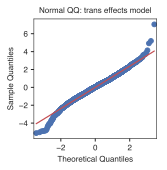

In [40]:
res = mod.resid

fig, ax = plt.subplots(figsize=(2.2, 2.2), ncols=1, nrows=1)
sm.qqplot(res, line='s', ax=ax)
ax.set_title("Normal QQ: trans effects model")
fig.savefig("avg_activ_qq.pdf", dpi="figure", bbox_inches="tight")

In [41]:
reduced_llf = mod.llf
reduced_llf

-5206.6779727619269

In [42]:
reduced_rsq = mod.rsquared
reduced_rsq

0.017730022145315161

## 4. add motifs to model

In [43]:
data_filt["tss_index"] = data_filt["tss_id"] + "__" + data_filt["tss_tile_num"]

In [44]:
human_motifs["hg19_index"] = human_motifs["hg19_id"] + "__" + human_motifs["tss_tile_num"]
mouse_motifs["mm9_index"] = mouse_motifs["mm9_id"] + "__" + mouse_motifs["tss_tile_num"]

In [45]:
uniq_motifs = list(set(list(human_motifs["#pattern name"].unique()) + list(mouse_motifs["#pattern name"].unique())))
len(uniq_motifs)

464

In [46]:
def tss_motif(row):
    if row.human_motif:
        return True
    elif row.mouse_motif:
        return True
    else:
        return False

In [47]:
motif_results = {}

for i, motif_id in enumerate(uniq_motifs):
    tmp = data_filt.copy()
    
    # determine whether motif is in human or mouse sequence
    human_motifs_sub = human_motifs[human_motifs["#pattern name"] == motif_id]["hg19_index"].unique()
    mouse_motifs_sub = mouse_motifs[mouse_motifs["#pattern name"] == motif_id]["mm9_index"].unique()
    tmp["human_motif"] = tmp["tss_index"].isin(human_motifs_sub)
    tmp["mouse_motif"] = tmp["tss_index"].isin(mouse_motifs_sub)
    tmp["tss_motif"] = tmp.apply(tss_motif, axis=1)
    n_w_motif = tmp["tss_motif"].sum()
    
    # make full model
    full_mod = smf.ols(formula='logFC_trans ~ gc + cpg + tss_motif', 
                       data=tmp).fit()
    full_llf = full_mod.llf
    full_rsq = full_mod.rsquared
    
#     # perform likelihood ratio test
#     lr, p = lrtest(reduced_llf, full_llf)
    
    # calculate additional variance explained
    rsq = full_rsq - reduced_rsq
    
    # record beta
    beta = list(full_mod.params)[1]
    
    # beta p
    beta_p = list(full_mod.pvalues)[1]
    
    print("(#%s) %s: n w/ motif: %s ... p: %s, rsquared: %s" % (i+1, motif_id, len(tmp), beta_p, rsq))
    motif_results[motif_id] = {"rsq": rsq, "beta": beta, "beta_p": beta_p, "n_w_motif": n_w_motif}

(#1) M07230_1: n w/ motif: 3276 ... p: 0.225176859734, rsquared: 0.000441590582103
(#2) M06129_1: n w/ motif: 3276 ... p: 0.000908733565292, rsquared: 0.00329866451125
(#3) M09001_1: n w/ motif: 3276 ... p: 0.288759906277, rsquared: 0.00033784220691
(#4) M05902_1: n w/ motif: 3276 ... p: 0.580342660232, rsquared: 9.17766321348e-05
(#5) ZNF587: n w/ motif: 3276 ... p: 0.0258517268091, rsquared: 0.00148988620576
(#6) M09096_1: n w/ motif: 3276 ... p: 0.00447313447485, rsquared: 0.00242333612568
(#7) M05704_1: n w/ motif: 3276 ... p: 1.63419227118e-08, rsquared: 0.00952754055402
(#8) M06885_1: n w/ motif: 3276 ... p: 0.00235890600623, rsquared: 0.00277247636471
(#9) M08932_1: n w/ motif: 3276 ... p: 0.0987599378737, rsquared: 0.000817978998904
(#10) M05596_1: n w/ motif: 3276 ... p: 0.290494829463, rsquared: 0.000335420750455
(#11) M10322_1: n w/ motif: 3276 ... p: 0.0119858229935, rsquared: 0.00189364408156
(#12) M10359_1: n w/ motif: 3276 ... p: 5.97894882913e-12, rsquared: 0.0141104709

(#99) M05787_1: n w/ motif: 3276 ... p: 0.136469973574, rsquared: 0.000665525500835
(#100) M10350_1: n w/ motif: 3276 ... p: 0.484298806168, rsquared: 0.000146861936613
(#101) M06244_1: n w/ motif: 3276 ... p: 0.661950222913, rsquared: 5.73952075134e-05
(#102) M05650_1: n w/ motif: 3276 ... p: 1.27161711946e-11, rsquared: 0.0136727524416
(#103) M09037_1: n w/ motif: 3276 ... p: 0.306677615779, rsquared: 0.000313690843692
(#104) M10271_1: n w/ motif: 3276 ... p: 0.00591311687416, rsquared: 0.00227224397712
(#105) M06207_1: n w/ motif: 3276 ... p: 5.20279929784e-08, rsquared: 0.00885914945333
(#106) M09053_1: n w/ motif: 3276 ... p: 0.245387947856, rsquared: 0.000405066237643
(#107) ZNF101: n w/ motif: 3276 ... p: 0.516351354079, rsquared: 0.000126449904673
(#108) M06176_1: n w/ motif: 3276 ... p: 0.926368270467, rsquared: 2.56430052303e-06
(#109) M09387_1: n w/ motif: 3276 ... p: 0.358069130296, rsquared: 0.000253575142816
(#110) M08897_1: n w/ motif: 3276 ... p: 0.12353645703, rsquared

(#197) M10351_1: n w/ motif: 3276 ... p: 0.119799996135, rsquared: 0.000726317989026
(#198) M06055_1: n w/ motif: 3276 ... p: 0.000240538350615, rsquared: 0.00404040598146
(#199) M09385_1: n w/ motif: 3276 ... p: 0.446939908071, rsquared: 0.000173649806323
(#200) M08993_1: n w/ motif: 3276 ... p: 0.834162808728, rsquared: 1.31610904985e-05
(#201) M10377_1: n w/ motif: 3276 ... p: 0.262205059658, rsquared: 0.000377365729618
(#202) ZNF223: n w/ motif: 3276 ... p: 0.607381879852, rsquared: 7.92644897374e-05
(#203) M09381_1: n w/ motif: 3276 ... p: 3.10952526403e-06, rsquared: 0.00650812284719
(#204) M10438_1: n w/ motif: 3276 ... p: 0.00528245046943, rsquared: 0.00233320825369
(#205) M08474_1: n w/ motif: 3276 ... p: 0.134205904215, rsquared: 0.00067328130606
(#206) M06242_1: n w/ motif: 3276 ... p: 0.301541507699, rsquared: 0.000320424591269
(#207) M10416_1: n w/ motif: 3276 ... p: 0.000823169072351, rsquared: 0.00335354164471
(#208) ZNF571: n w/ motif: 3276 ... p: 0.0419875473309, rsqua

(#295) M09197_1: n w/ motif: 3276 ... p: 0.155894661162, rsquared: 0.000604399678698
(#296) ZNF891: n w/ motif: 3276 ... p: 0.0155439206343, rsquared: 0.00175601973551
(#297) M09373_1: n w/ motif: 3276 ... p: 0.680856317936, rsquared: 5.07901311783e-05
(#298) M06208_1: n w/ motif: 3276 ... p: 0.879975084326, rsquared: 6.84606356616e-06
(#299) M10374_1: n w/ motif: 3276 ... p: 0.132760156462, rsquared: 0.000678310776794
(#300) M08884_1: n w/ motif: 3276 ... p: 2.83557124696e-11, rsquared: 0.0132076729204
(#301) M08489_1: n w/ motif: 3276 ... p: 0.397239069225, rsquared: 0.000215156435286
(#302) M00404_1: n w/ motif: 3276 ... p: 0.612152030409, rsquared: 7.71773042302e-05
(#303) M08959_1: n w/ motif: 3276 ... p: 0.0372963177114, rsquared: 0.00130127305061
(#304) M06138_1: n w/ motif: 3276 ... p: 0.0121462359742, rsquared: 0.00188658141929
(#305) M09436_1: n w/ motif: 3276 ... p: 0.1703517388, rsquared: 0.000564262597762
(#306) M09278_1: n w/ motif: 3276 ... p: 0.0107292413923, rsquared: 

(#393) M07575_1: n w/ motif: 3276 ... p: 0.279018263594, rsquared: 0.000351790351145
(#394) M06027_1: n w/ motif: 3276 ... p: 0.754300378444, rsquared: 2.94099370789e-05
(#395) M10375_1: n w/ motif: 3276 ... p: 0.00213828484577, rsquared: 0.00282635076972
(#396) M09550_1: n w/ motif: 3276 ... p: 0.00165831165801, rsquared: 0.00296615016442
(#397) M08881_1: n w/ motif: 3276 ... p: 2.43097734299e-11, rsquared: 0.0132969455425
(#398) M05699_1: n w/ motif: 3276 ... p: 3.00404128023e-09, rsquared: 0.0105065926999
(#399) M09353_1: n w/ motif: 3276 ... p: 0.897358325833, rsquared: 4.99639190277e-06
(#400) ZNF398: n w/ motif: 3276 ... p: 0.000339478924816, rsquared: 0.00384734695764
(#401) M10344_1: n w/ motif: 3276 ... p: 4.33812746252e-06, rsquared: 0.00631768244482
(#402) M06446_1: n w/ motif: 3276 ... p: 0.272359435511, rsquared: 0.000361682884188
(#403) M06240_1: n w/ motif: 3276 ... p: 0.266842176176, rsquared: 0.000370111776081
(#404) M06052_1: n w/ motif: 3276 ... p: 7.52226686258e-05,

In [48]:
motif_results = pd.DataFrame.from_dict(motif_results, orient="index").reset_index()
motif_results = motif_results[motif_results["n_w_motif"] >= 10]
print(len(motif_results))
motif_results.head()

446


,index,rsq,beta,beta_p,n_w_motif
0,HKR1,0.010033,-0.262921,6.817037e-09,1402
2,M00224_1,0.000258,-0.253338,3.537124e-01,19
3,M00226_1,0.010558,0.683393,2.749421e-09,110
4,M00242_1,0.000461,-0.338620,2.154315e-01,19
5,M00255_1,0.008270,0.455096,1.446522e-07,200


In [49]:
motif_results["padj"] = multicomp.multipletests(motif_results["beta_p"], method="fdr_bh")[1]
len(motif_results[motif_results["padj"] < 0.05])

174

In [50]:
motif_results.sort_values(by="padj").head(10)

,index,rsq,beta,beta_p,n_w_motif,padj
376,M10360_1,0.030284,0.442293,4.422643e-24,1572,1.972499e-21
16,M00616_1,0.026813,0.421552,1.809468e-21,1537,4.035115e-19
13,M00600_1,0.019134,0.355744,1.038651e-15,1498,1.544127e-13
324,M09501_1,0.018086,0.419838,6.329180e-15,604,7.057035e-13
56,M05647_1,0.017593,0.442382,1.478576e-14,507,1.318890e-12
49,M05584_1,0.017310,0.766481,2.409561e-14,145,1.791107e-12
325,M09509_1,0.017141,0.426725,3.221685e-14,541,2.052674e-12
277,M09177_1,0.015963,0.320576,2.454548e-13,1408,1.368410e-11
148,M06390_1,0.015833,0.424651,3.071693e-13,491,1.522194e-11
11,M00554_1,0.015514,0.320349,5.321047e-13,1391,2.373187e-11


## 5. join w/ TF info

In [51]:
motif_results_mrg = motif_results.merge(sig_motifs, on="index", suffixes=("_trans", "_activ"))
motif_results_mrg.sort_values(by="padj_trans").head()

,index,rsq_trans,beta_trans,beta_p,n_w_motif,padj_trans,lr_test,pval,rsq_activ,beta_activ,padj_activ,short_id,HGNC symbol,activ_or_repr,no_CAGE_enr,eRNA_enr,lncRNA_enr,mRNA_enr
381,M10360_1,0.030284,0.442293,4.422643e-24,1572,1.972499e-21,411.846715,1.452601e-91,0.024821,0.402253,4.927948e-90,M10360_1,SP2,activating,NaN,NaN,2.0,3.0
16,M00616_1,0.026813,0.421552,1.809468e-21,1537,4.035115e-19,432.422883,4.825598e-96,0.026042,0.413977,1.769821e-94,M00616_1,KLF8,activating,NaN,NaN,2.0,3.0
13,M00600_1,0.019134,0.355744,1.038651e-15,1498,1.544127e-13,436.566496,6.049445e-97,0.026288,0.421643,2.280305e-95,M00600_1,KLF7,activating,NaN,NaN,2.0,3.0
326,M09501_1,0.018086,0.419838,6.329180e-15,604,7.057035e-13,618.654145,1.467156e-136,0.037010,0.725789,9.954654e-135,M09501_1,ELF1,activating,NaN,NaN,NaN,3.0
60,M05647_1,0.017593,0.442382,1.478576e-14,507,1.318890e-12,490.517268,1.099666e-108,0.029479,0.684081,4.712929e-107,M05647_1,EHF,activating,NaN,NaN,NaN,3.0


In [52]:
sig_results = motif_results_mrg[(motif_results_mrg["padj_trans"] < 0.05)]
sig_results["abs_beta"] = np.abs(sig_results["beta_trans"])
sig_results = sig_results.sort_values(by="abs_beta", ascending=False)

In [53]:
pal = {"repressing": sns.color_palette("pastel")[3], "activating": sns.color_palette("pastel")[0]}

In [54]:
full_pal = {}
for i, row in sig_results.iterrows():
    full_pal[row["HGNC symbol"]] = pal[row["activ_or_repr"]]

In [55]:
sig_results_sub = sig_results.head(50)

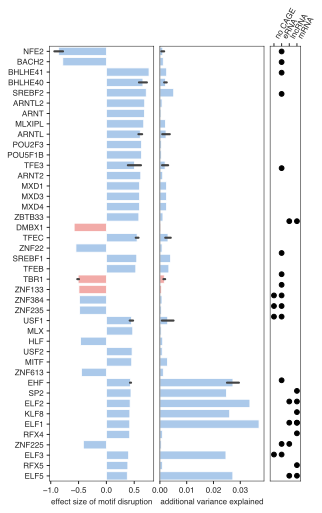

In [56]:
fig = plt.figure(figsize=(4.5, 8))

ax1 = plt.subplot2grid((1, 7), (0, 0), colspan=3)
ax2 = plt.subplot2grid((1, 7), (0, 3), colspan=3)
ax3 = plt.subplot2grid((1, 7), (0, 6), colspan=1)

yvals = []
symbs = []
c = 0
for i, row in sig_results_sub.iterrows():
    symb = row["HGNC symbol"]
    if symb not in symbs:
        yvals.append(c)
        symbs.append(symb)
        c += 1
    else:
        yvals.append(c)

sig_results_sub["yval"] = yvals
sns.barplot(y="HGNC symbol", x="beta_trans", data=sig_results_sub, palette=full_pal, ax=ax1)
ax1.set_ylabel("")
ax1.set_xlabel("effect size of motif disruption")

sns.barplot(y="HGNC symbol", x="rsq_activ", data=sig_results_sub, palette=full_pal, ax=ax2)
ax2.set_ylabel("")
ax2.tick_params(left=False, labelleft=False)
ax2.set_xlabel("additional variance explained")

melt = pd.melt(sig_results_sub, id_vars=["HGNC symbol", "yval"], value_vars=["no_CAGE_enr", "eRNA_enr",
                                                                                 "lncRNA_enr", "mRNA_enr"])
ax3.plot(melt["value"], melt["yval"], 'o', color="black")
ax3.set_xlim((-0.5, 3.5))
ax3.set_ylim((np.max(yvals)-0.5, -0.5))
ax3.tick_params(labelleft=False, labelbottom=False, bottom=False, left=False, top=True, labeltop=True)
ax3.xaxis.set_ticks([0, 1, 2, 3])
ax3.set_xticklabels(["no CAGE", "eRNA", "lncRNA", "mRNA"], rotation=60, ha="left", va="bottom")

plt.show()
fig.savefig("trans_motif_enrichment.pdf", dpi="figure", bbox_inches="tight")
plt.close()

## 6. join with expression information

In [57]:
orth_expr[orth_expr["gene_name_human"] == "POU5F1B"]

,gene_id_human,gene_name_human,mean_tpm_human,gene_id_mouse,gene_name_mouse,mean_tpm_mouse,baseMean,log2FoldChange,lfcSE,padj,sig


In [58]:
orth_expr.head()

,gene_id_human,gene_name_human,mean_tpm_human,gene_id_mouse,gene_name_mouse,mean_tpm_mouse,baseMean,log2FoldChange,lfcSE,padj,sig
0,ENSG00000197921,HES5,101.620874,ENSMUSG00000048001,Hes5,0.000000,42.463063,9.220488,1.288307,1.707594e-12,sig
1,ENSG00000142611,PRDM16,127.168363,ENSMUSG00000039410,Prdm16,1160.183127,726.532277,-3.087431,0.291775,1.049818e-25,sig
2,ENSG00000078900,TP73,104.875666,ENSMUSG00000029026,Trp73,1094.785279,679.159979,-3.288922,0.188538,2.171432e-67,sig
3,ENSG00000173673,HES3,1260.850395,ENSMUSG00000028946,Hes3,6.791385,529.616567,7.618832,0.348308,4.031740e-105,sig
4,ENSG00000069812,HES2,30.322266,ENSMUSG00000028940,Hes2,11.737072,19.474793,1.493640,0.690207,3.923633e-02,not sig


In [59]:
trans_orth = motif_results_mrg.merge(orth_expr, left_on="HGNC symbol", right_on="gene_name_human")
len(trans_orth)

375

In [60]:
# fisher's exact to see if trans are enriched in DE TFs
trans_ids = trans_orth[trans_orth["padj_trans"] < 0.05]["index"].unique()
no_trans_ids = trans_orth[trans_orth["padj_trans"] >= 0.05]["index"].unique()
DE_ids = trans_orth[trans_orth["sig"] == "sig"]["index"].unique()

trans_w_DE = len([x for x in trans_ids if x in DE_ids])
trans_wo_DE = len([x for x in trans_ids if x not in DE_ids])
no_trans_w_DE = len([x for x in no_trans_ids if x in DE_ids])
no_trans_wo_DE = len([x for x in no_trans_ids if x not in DE_ids])

# fisher's exact test
arr = np.zeros((2, 2))
arr[0, 0] = trans_w_DE
arr[0, 1] = trans_wo_DE
arr[1, 0] = no_trans_w_DE
arr[1, 1] = no_trans_wo_DE

odds, p = stats.fisher_exact(arr)
print(odds)
print(p)

0.641221374046
0.0495267391429


In [61]:
trans_orth_sig = trans_orth[trans_orth["padj_trans"] < 0.05]
trans_orth_sig["abs_beta"] = np.abs(trans_orth_sig["beta_trans"])
trans_orth_sig = trans_orth_sig.sort_values(by="abs_beta", ascending=False)
trans_orth_sig["corrected_l2fc"] = -trans_orth_sig["log2FoldChange"]
len(trans_orth_sig)

147

In [62]:
trans_orth_sub = trans_orth_sig[trans_orth_sig["sig"] == "sig"]
len(trans_orth_sub)

72

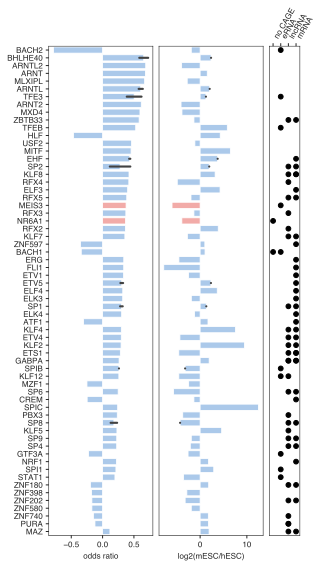

In [63]:
fig = plt.figure(figsize=(4.5, 9))

ax1 = plt.subplot2grid((1, 7), (0, 0), colspan=3)
ax2 = plt.subplot2grid((1, 7), (0, 3), colspan=3)
ax3 = plt.subplot2grid((1, 7), (0, 6), colspan=1)

yvals = []
symbs = []
c = 0
for i, row in trans_orth_sub.iterrows():
    symb = row["HGNC symbol"]
    if symb not in symbs:
        yvals.append(c)
        symbs.append(symb)
        c += 1
    else:
        yvals.append(c)

trans_orth_sub["yval"] = yvals
sns.barplot(y="HGNC symbol", x="beta_trans", data=trans_orth_sub, palette=full_pal, ax=ax1)
ax1.set_ylabel("")
ax1.set_xlabel("odds ratio")

sns.barplot(y="HGNC symbol", x="corrected_l2fc", data=trans_orth_sub, palette=full_pal, ax=ax2)
ax2.set_ylabel("")
ax2.tick_params(left=False, labelleft=False)
ax2.set_xlabel("log2(mESC/hESC)")

melt = pd.melt(trans_orth_sub, id_vars=["HGNC symbol", "yval"], value_vars=["no_CAGE_enr", "eRNA_enr",
                                                                                 "lncRNA_enr", "mRNA_enr"])
ax3.plot(melt["value"], melt["yval"], 'o', color="black")
ax3.set_xlim((-0.5, 3.5))
ax3.set_ylim((np.max(yvals)-0.5, -0.5))
ax3.tick_params(labelleft=False, labelbottom=False, bottom=False, left=False, top=True, labeltop=True)
ax3.xaxis.set_ticks([0, 1, 2, 3])
ax3.set_xticklabels(["no CAGE", "eRNA", "lncRNA", "mRNA"], rotation=60, ha="left", va="bottom")

plt.show()
fig.savefig("trans_motif_enrichment.with_expr.pdf", dpi="figure", bbox_inches="tight")
plt.close()

In [64]:
# filter to those where direction matches
trans_orth_sub["direction_match"] = trans_orth_sub.apply(direction_match, axis=1)
trans_orth_sub.direction_match.value_counts()

match       38
no match    34
Name: direction_match, dtype: int64

In [65]:
trans_orth_match = trans_orth_sub[trans_orth_sub["direction_match"] == "match"]

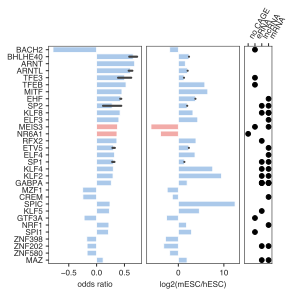

In [66]:
fig = plt.figure(figsize=(4, 4))

ax1 = plt.subplot2grid((1, 7), (0, 0), colspan=3)
ax2 = plt.subplot2grid((1, 7), (0, 3), colspan=3)
ax3 = plt.subplot2grid((1, 7), (0, 6), colspan=1)

yvals = []
symbs = []
c = 0
for i, row in trans_orth_match.iterrows():
    symb = row["HGNC symbol"]
    if symb not in symbs:
        yvals.append(c)
        symbs.append(symb)
        c += 1
    else:
        yvals.append(c)

trans_orth_match["yval"] = yvals
sns.barplot(y="HGNC symbol", x="beta_trans", data=trans_orth_match, palette=full_pal, ax=ax1)
ax1.set_ylabel("")
ax1.set_xlabel("odds ratio")

sns.barplot(y="HGNC symbol", x="corrected_l2fc", data=trans_orth_match, palette=full_pal, ax=ax2)
ax2.set_ylabel("")
ax2.tick_params(left=False, labelleft=False)
ax2.set_xlabel("log2(mESC/hESC)")

melt = pd.melt(trans_orth_match, id_vars=["HGNC symbol", "yval"], value_vars=["no_CAGE_enr", "eRNA_enr",
                                                                                 "lncRNA_enr", "mRNA_enr"])
ax3.plot(melt["value"], melt["yval"], 'o', color="black")
ax3.set_xlim((-0.5, 3.5))
ax3.set_ylim((np.max(yvals)-0.5, -0.5))
ax3.tick_params(labelleft=False, labelbottom=False, bottom=False, left=False, top=True, labeltop=True)
ax3.xaxis.set_ticks([0, 1, 2, 3])
ax3.set_xticklabels(["no CAGE", "eRNA", "lncRNA", "mRNA"], rotation=60, ha="left", va="bottom")

plt.show()
fig.savefig("trans_motif_enrichment.with_expr.match_only.pdf", dpi="figure", bbox_inches="tight")
plt.close()

## 7. join w/ % similarity information

In [67]:
orth_sub = orth[["Gene name", "Mouse gene name", "%id. target Mouse gene identical to query gene"]]
orth_sub.columns = ["human_gene_name", "mouse_gene_name", "perc_similarity"]

In [68]:
trans_orth = trans_orth.merge(orth_sub, left_on="HGNC symbol", right_on="human_gene_name").drop_duplicates()
print(len(trans_orth))
trans_orth.sample(5)

368


,index,rsq_trans,beta_trans,beta_p,n_w_motif,padj_trans,lr_test,pval,rsq_activ,beta_activ,...,gene_name_mouse,mean_tpm_mouse,baseMean,log2FoldChange,lfcSE,padj,sig,human_gene_name,mouse_gene_name,perc_similarity
3167,M10400_1,2.008853e-04,-0.114158,4.133561e-01,74,5.406359e-01,7.221760,7.202504e-03,0.000442,-0.136778,...,Zfp784,2.272669,238.463080,8.052660,0.590852,1.079120e-41,sig,ZNF784,Zfp784,77.7090
2437,M09045_1,5.484382e-06,0.012458,8.924917e-01,179,9.257007e-01,12.924985,3.242252e-04,0.000790,-0.145596,...,Pax6,110.631341,204.911579,1.715259,0.264651,1.774791e-10,sig,PAX6,Pax6,99.7706
1859,M06968_1,1.253363e-02,0.583309,9.069165e-11,190,1.617939e-09,18.680551,1.545509e-05,0.001142,0.195653,...,Zbtb33,1258.270757,1945.372500,1.320151,0.075051,1.701425e-68,sig,ZBTB33,Zbtb33,87.9464
3198,ZKSCAN5,8.570949e-07,0.003524,9.573905e-01,365,9.607308e-01,57.324281,3.695645e-14,0.003499,0.220844,...,Zkscan5,2023.338293,2006.551581,0.089745,0.082827,3.213556e-01,not sig,ZKSCAN5,Zkscan5,78.6651
895,M05934_1,1.432496e-02,-0.934405,4.130915e-12,82,1.417222e-10,9.212466,2.403727e-03,0.000563,0.160023,...,Nfe2,107.116451,105.571864,0.058781,0.317658,8.673761e-01,not sig,NFE2,Nfe2,88.7399


In [69]:
trans_orth["corrected_l2fc"] = -trans_orth_sub["log2FoldChange"]
trans_orth["abs_l2fc"] = np.abs(trans_orth["log2FoldChange"])
trans_orth["sig_status"] = trans_orth.apply(sig_status, axis=1)
trans_orth.head()

,index,rsq_trans,beta_trans,beta_p,n_w_motif,padj_trans,lr_test,pval,rsq_activ,beta_activ,...,log2FoldChange,lfcSE,padj,sig,human_gene_name,mouse_gene_name,perc_similarity,corrected_l2fc,abs_l2fc,sig_status
0,M00224_1,0.000258,-0.253338,3.537124e-01,19,4.876613e-01,8.999747,0.002700,0.000550,-0.228712,...,8.646795,1.336959,1.940848e-10,sig,TWIST2,Twist2,100.0000,NaN,8.646795,not sig
2,M00226_1,0.010558,0.683393,2.749421e-09,110,3.503547e-08,6.933266,0.008461,0.000424,0.133341,...,-1.530482,0.094132,9.934581e-59,sig,ARNT,Arnt,91.5082,NaN,1.530482,sig
14,M00242_1,0.000461,-0.338620,2.154315e-01,19,3.431517e-01,18.650533,0.000016,0.001140,-0.321524,...,-5.542494,1.966846,6.621262e-03,sig,SCX,Scx,95.0249,NaN,5.542494,not sig
15,M00242_1,0.000461,-0.338620,2.154315e-01,19,3.431517e-01,18.650533,0.000016,0.001140,-0.321524,...,0.646613,0.336126,6.845270e-02,not sig,TCF15,Tcf15,91.4573,3.212197,0.646613,not sig
16,M00242_1,0.000461,-0.338620,2.154315e-01,19,3.431517e-01,18.650533,0.000016,0.001140,-0.321524,...,6.231366,1.975704,2.278180e-03,sig,TCF23,Tcf23,75.7009,NaN,6.231366,not sig


In [70]:
trans_orth.sig_status.value_counts()

not sig    223
sig        145
Name: sig_status, dtype: int64

In [71]:
order = ["not sig", "sig"]
palette = {"not sig": "gray", "sig": sns.color_palette("Set2")[2]}

0.0114969928906


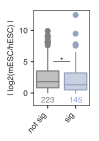

In [72]:
fig = plt.figure(figsize=(1, 1.75))
ax = sns.boxplot(data=trans_orth, x="sig_status", y="abs_l2fc", palette=palette, order=order,
                 flierprops = dict(marker='o', markersize=5))
mimic_r_boxplot(ax)

ax.set_xticklabels(order, rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_ylabel("| log2(mESC/hESC) |")

for i, label in enumerate(order):
    n = len(trans_orth[trans_orth["sig_status"] == label])
    ax.annotate(str(n), xy=(i, -0.6), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='top', 
                color=palette[label], size=fontsize)

ax.set_ylim((-2, 13.2))

# calc p-vals b/w dists
dist1 = np.asarray(trans_orth[trans_orth["sig_status"] == "sig"]["abs_l2fc"])
dist2 = np.asarray(trans_orth[trans_orth["sig_status"] != "sig"]["abs_l2fc"])

dist1 = dist1[~np.isnan(dist1)]
dist2 = dist2[~np.isnan(dist2)]

u, pval = stats.mannwhitneyu(dist1, dist2, alternative="two-sided", use_continuity=False)
print(pval)

annotate_pval(ax, 0.2, 0.8, 5, 0, 4.5, pval, fontsize)

plt.show()
fig.savefig("trans_v_l2fc_boxplot.pdf", dpi="figure", bbox_inches="tight")
plt.close()

0.545359674035


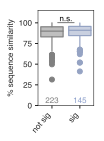

In [73]:
fig = plt.figure(figsize=(1, 1.75))
ax = sns.boxplot(data=trans_orth, x="sig_status", y="perc_similarity", palette=palette, order=order,
                 flierprops = dict(marker='o', markersize=5))
mimic_r_boxplot(ax)

ax.set_xticklabels(order, rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_ylabel("% sequence similarity")

for i, label in enumerate(order):
    n = len(trans_orth[trans_orth["sig_status"] == label])
    ax.annotate(str(n), xy=(i, 10), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='top', 
                color=palette[label], size=fontsize)

ax.set_ylim((0, 115))

# calc p-vals b/w dists
dist1 = np.asarray(trans_orth[trans_orth["sig_status"] == "sig"]["perc_similarity"])
dist2 = np.asarray(trans_orth[trans_orth["sig_status"] != "sig"]["perc_similarity"])

dist1 = dist1[~np.isnan(dist1)]
dist2 = dist2[~np.isnan(dist2)]

u, pval = stats.mannwhitneyu(dist1, dist2, alternative="two-sided", use_continuity=False)
print(pval)

annotate_pval(ax, 0.2, 0.8, 100, 0, 100, pval, fontsize)

plt.show()
fig.savefig("trans_v_similarity_boxplot.pdf", dpi="figure", bbox_inches="tight")
plt.close()

## 8. look at strength of motifs associated w/ trans effects

In [74]:
data_filt.head()

,logFC_trans,gc,cpg,padj,tss_id,tss_tile_num,trans_status,tss_index
0,-1.521999,0.838347,0.948720,1.812116e-03,h.2,tile1,no trans effect,h.2__tile1
3,0.833409,-1.274771,-0.321568,1.368040e-14,h.5,tile1,no trans effect,h.5__tile1
4,0.205700,-0.944596,-0.140098,3.003835e-10,h.6,tile1,no trans effect,h.6__tile1
5,0.145846,0.111962,-0.321568,7.028182e-155,h.7,tile1,no trans effect,h.7__tile1
9,-1.480379,1.036451,0.948720,0.000000e+00,h.11,tile1,no trans effect,h.11__tile1


In [75]:
human_motifs.columns

Index(['#pattern name', 'sequence name', 'start', 'stop', 'strand_x', 'score',
       'p-value', 'q-value', 'matched sequence', 'elem_key', 'elem', 'element',
       'tile_type', 'element_id', 'name', 'tile_number', 'chrom', 'strand_y',
       'actual_start', 'actual_end', 'dupe_info', 'tss_id', 'species',
       'tss_tile_num', 'hg19_id', 'biotype_hg19', 'minimal_biotype_hg19',
       'stem_exp_hg19', 'orig_species', 'hg19_index'],
      dtype='object')

In [76]:
trans_ids = data_filt[data_filt["trans_status"] == "significant trans effect"]["tss_index"].unique()
len(trans_ids)

548

In [77]:
filt_ids = list(data_filt["tss_index"].unique())
len(filt_ids)

3158

In [78]:
len(sig_results)

179

In [79]:
uniq_motifs_sig = list(sig_results["index"].unique())

In [80]:
strength_results = pd.DataFrame()

for i, motif_id in enumerate(uniq_motifs_sig):
    
    # subset motif dfs to occurrences
    human_motifs_sub = human_motifs[human_motifs["#pattern name"] == motif_id]
    mouse_motifs_sub = mouse_motifs[mouse_motifs["#pattern name"] == motif_id]
    
    # subset motif dfs to data filt ids
    human_motifs_sub = human_motifs_sub[human_motifs_sub["hg19_index"].isin(filt_ids)]
    mouse_motifs_sub = mouse_motifs_sub[mouse_motifs_sub["mm9_index"].isin(filt_ids)]
    
    # subset into trans vs. no trans effects
    human_motifs_sub["trans_status"] = human_motifs_sub["hg19_index"].isin(trans_ids)
    mouse_motifs_sub["trans_status"] = mouse_motifs_sub["mm9_index"].isin(trans_ids)
    
    # get data we need
    human_sub = human_motifs_sub[["#pattern name", "score", "trans_status"]]
    mouse_sub = mouse_motifs_sub[["#pattern name", "score", "trans_status"]]
    human_sub.columns = ["index", "motif_score", "trans_status"]
    mouse_sub.columns = ["index", "motif_score", "trans_status"]
    
    # append to df
    strength_results = strength_results.append(human_sub).append(mouse_sub)
    print("(#%s) %s" % (i+1, motif_id))

(#1) M05934_1
(#2) M09445_1
(#3) M08957_1
(#4) M05584_1
(#5) M08516_1
(#6) M06141_1
(#7) M00267_1
(#8) M00226_1
(#9) M05908_1
(#10) M05565_1
(#11) M06004_1
(#12) M06019_1
(#13) M06205_1
(#14) M08469_1
(#15) M05548_1
(#16) M05580_1
(#17) M06968_1
(#18) M08571_1
(#19) M09241_1
(#20) M08470_1
(#21) M10344_1
(#22) M09970_1
(#23) M06206_1
(#24) M06207_1
(#25) M06149_1
(#26) ZNF133
(#27) M06148_1
(#28) M10409_1
(#29) ZNF235
(#30) M09265_1
(#31) M08929_1
(#32) M05791_1
(#33) M09267_1
(#34) M00255_1
(#35) ZNF613
(#36) M05647_1
(#37) M10360_1
(#38) M09509_1
(#39) M06390_1
(#40) M00616_1
(#41) M09501_1
(#42) M06218_1
(#43) M06052_1
(#44) ZNF225
(#45) M05650_1
(#46) M09237_1
(#47) M06055_1
(#48) M05654_1
(#49) M05897_1
(#50) M06050_1
(#51) M06231_1
(#52) M09009_1
(#53) M06048_1
(#54) M10305_1
(#55) M09317_1
(#56) M09537_1
(#57) M06135_1
(#58) M00600_1
(#59) M09381_1
(#60) M09096_1
(#61) M05658_1
(#62) M06885_1
(#63) M09333_1
(#64) M05674_1
(#65) M05706_1
(#66) M05695_1
(#67) M10359_1
(#68) M01232

In [81]:
print(len(strength_results))
strength_results_mrg = strength_results.merge(sig_motifs, on="index")
strength_results_mrg.head()

185235


,index,motif_score,trans_status,lr_test,pval,rsq,beta,padj,short_id,HGNC symbol,activ_or_repr,no_CAGE_enr,eRNA_enr,lncRNA_enr,mRNA_enr
0,M05934_1,10.35710,False,9.212466,0.002404,0.000563,0.160023,0.00924,M05934_1,NFE2,activating,NaN,1.0,NaN,NaN
1,M05934_1,8.68367,False,9.212466,0.002404,0.000563,0.160023,0.00924,M05934_1,NFE2,activating,NaN,1.0,NaN,NaN
2,M05934_1,15.70410,False,9.212466,0.002404,0.000563,0.160023,0.00924,M05934_1,NFE2,activating,NaN,1.0,NaN,NaN
3,M05934_1,15.70410,False,9.212466,0.002404,0.000563,0.160023,0.00924,M05934_1,NFE2,activating,NaN,1.0,NaN,NaN
4,M05934_1,11.39800,False,9.212466,0.002404,0.000563,0.160023,0.00924,M05934_1,NFE2,activating,NaN,1.0,NaN,NaN


In [82]:
uniq_motifs_sig1 = uniq_motifs_sig[0:41]
uniq_motifs_sig2 = uniq_motifs_sig[41:82]
uniq_motifs_sig3 = uniq_motifs_sig[82:123]
uniq_motifs_sig4 = uniq_motifs_sig[123:]
print(len(uniq_motifs_sig1))
print(len(uniq_motifs_sig2))
print(len(uniq_motifs_sig3))
print(len(uniq_motifs_sig4))

41
41
41
51


In [83]:
pal = {False: "gray", True: sns.color_palette("Set2")[2]}
hue_order = [False, True]

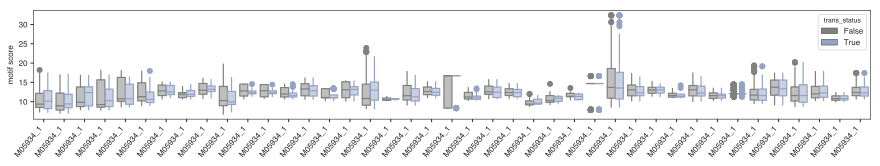

In [84]:
fig = plt.figure(figsize=(15, 2))

sub = strength_results_mrg[strength_results_mrg["index"].isin(uniq_motifs_sig1)]
ax = sns.boxplot(data=sub, x="index", y="motif_score", hue="trans_status", hue_order=hue_order, palette=pal,
                 flierprops = dict(marker='o', markersize=5))
mimic_r_boxplot(ax)

ax.set_xlabel("")
ax.set_xticklabels(sub["index"], rotation=50, ha="right", va="top")
ax.set_ylabel("motif score")